In [2]:
import nibabel as nib
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
#from tensorflow import keras

import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda

from keras.metrics import MeanIoU
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import CSVLogger
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.losses import binary_crossentropy

#from focal_loss import BinaryFocalLoss

In [3]:
TRAIN_DATASET_PATH = 'C:\\Users\\Anita\\Datasets\\BraTS2021_Training_Data/'
nSample = os.listdir(TRAIN_DATASET_PATH)
len(nSample)

1251

In [4]:
train_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_ids = pathListIntoIds(train_directories) 

In [5]:
len(train_ids)

1250

In [6]:
train_ids

['BraTS2021_00000',
 'BraTS2021_00002',
 'BraTS2021_00003',
 'BraTS2021_00005',
 'BraTS2021_00006',
 'BraTS2021_00008',
 'BraTS2021_00009',
 'BraTS2021_00011',
 'BraTS2021_00012',
 'BraTS2021_00014',
 'BraTS2021_00016',
 'BraTS2021_00017',
 'BraTS2021_00018',
 'BraTS2021_00019',
 'BraTS2021_00020',
 'BraTS2021_00021',
 'BraTS2021_00022',
 'BraTS2021_00024',
 'BraTS2021_00025',
 'BraTS2021_00026',
 'BraTS2021_00028',
 'BraTS2021_00030',
 'BraTS2021_00031',
 'BraTS2021_00032',
 'BraTS2021_00033',
 'BraTS2021_00035',
 'BraTS2021_00036',
 'BraTS2021_00043',
 'BraTS2021_00044',
 'BraTS2021_00045',
 'BraTS2021_00046',
 'BraTS2021_00048',
 'BraTS2021_00049',
 'BraTS2021_00051',
 'BraTS2021_00052',
 'BraTS2021_00053',
 'BraTS2021_00054',
 'BraTS2021_00056',
 'BraTS2021_00058',
 'BraTS2021_00059',
 'BraTS2021_00060',
 'BraTS2021_00061',
 'BraTS2021_00062',
 'BraTS2021_00063',
 'BraTS2021_00064',
 'BraTS2021_00066',
 'BraTS2021_00068',
 'BraTS2021_00070',
 'BraTS2021_00071',
 'BraTS2021_00072',


In [7]:
from sklearn.model_selection import train_test_split
train_test_ids, val_ids = train_test_split(train_ids,test_size=0.2,shuffle=False) 
train_ids,  test_ids = train_test_split(train_test_ids,test_size=0.15,shuffle=False)
len(train_ids)

850

In [8]:
print("train ids:", len(train_ids))
print("val ids:", len(val_ids))
print("test ids:", len(test_ids))

train ids: 850
val ids: 250
test ids: 150


In [9]:
test_ids

['BraTS2021_01267',
 'BraTS2021_01268',
 'BraTS2021_01269',
 'BraTS2021_01270',
 'BraTS2021_01271',
 'BraTS2021_01272',
 'BraTS2021_01273',
 'BraTS2021_01274',
 'BraTS2021_01275',
 'BraTS2021_01276',
 'BraTS2021_01277',
 'BraTS2021_01278',
 'BraTS2021_01279',
 'BraTS2021_01280',
 'BraTS2021_01281',
 'BraTS2021_01282',
 'BraTS2021_01283',
 'BraTS2021_01284',
 'BraTS2021_01285',
 'BraTS2021_01286',
 'BraTS2021_01287',
 'BraTS2021_01288',
 'BraTS2021_01289',
 'BraTS2021_01290',
 'BraTS2021_01291',
 'BraTS2021_01292',
 'BraTS2021_01293',
 'BraTS2021_01294',
 'BraTS2021_01295',
 'BraTS2021_01296',
 'BraTS2021_01297',
 'BraTS2021_01298',
 'BraTS2021_01299',
 'BraTS2021_01300',
 'BraTS2021_01301',
 'BraTS2021_01302',
 'BraTS2021_01303',
 'BraTS2021_01304',
 'BraTS2021_01305',
 'BraTS2021_01306',
 'BraTS2021_01307',
 'BraTS2021_01308',
 'BraTS2021_01309',
 'BraTS2021_01310',
 'BraTS2021_01311',
 'BraTS2021_01312',
 'BraTS2021_01313',
 'BraTS2021_01314',
 'BraTS2021_01315',
 'BraTS2021_01316',


In [10]:
VOLUME_SLICES = 130
VOLUME_START_AT = 10
IMG_SIZE=192

In [11]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 1, shuffle=False):
       
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            
            case_path = os.path.join(TRAIN_DATASET_PATH, i)
            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata() 
            #mean = np.mean(T1w)
            #std = np.std(T1w)
            #T1w = (T1w - mean) / std
            flair=scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)
            #print(flair.shape)

#             data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
#             ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
            #print(seg.shape)
            #print(c)
        
            for j in range(VOLUME_SLICES):
                X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X=X.astype(np.float16)
#                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                y[j] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                y=y.astype(np.float16)
                #print(X.shape)
                #print(y.shape)
                    
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        #Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        print(X.shape)
        print(y.shape)
        print(mask.shape)
        #print(X.max())
        #print(X.min())
        #print(y.max())
        #z=X/np.max(X)
        #print(z.max())
        return X, mask
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [12]:
len(training_generator)
training_generator[2]

(130, 192, 192, 1)
(130, 192, 192)
(130, 192, 192, 4)


(array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
      

In [12]:
# defining the performance metrics
def dice_coeff(y_true,y_pred):
    y_true_new = K.flatten(y_true)
    y_pred_new = K.flatten(y_pred)
    denominator = K.sum(y_true_new) + K.sum(y_pred_new)
    numerator = K.sum(y_true_new * y_pred_new)
    return (2*numerator + 1)/(denominator+1)

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))        
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def iou(y_true,y_pred):
    intersec = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersec + 1) / (union- intersec + 1)
    return iou    

In [13]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
            
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [14]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((192, 192,1))
model = build_unet(input_layer, 'he_normal', 0.2)
#model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy', dice_coeff, precision,iou] )
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 96, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import CSVLogger
#filepath="2D-UNet-weights-improvement-{epoch:02d}.hdf5" 
checkpoint = ModelCheckpoint('2D-UNet-BraTsweights100.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
csv_logger = CSVLogger('training_BraTs21_2D_UNet100.log')
history =  model.fit(training_generator, epochs=100, steps_per_epoch=len(train_ids),
                    callbacks= [checkpoint, csv_logger, early_stop],validation_data = valid_generator)  

Epoch 1/100
850/850 [==============================] - 1149s 1s/step - loss: 0.0575 - accuracy: 0.9872 - mean_io_u: 0.7585 - dice_coef: 0.3353 - precision: 0.9894 - sensitivity: 0.9809 - specificity: 0.9971 - dice_coef_necrotic: 0.1179 - dice_coef_edema: 0.3454 - dice_coef_enhancing: 0.1480 - val_loss: 0.0473 - val_accuracy: 0.9892 - val_mean_io_u: 0.8130 - val_dice_coef: 0.3539 - val_precision: 0.9914 - val_sensitivity: 0.9876 - val_specificity: 0.9971 - val_dice_coef_necrotic: 0.1067 - val_dice_coef_edema: 0.3643 - val_dice_coef_enhancing: 0.1193

Epoch 00001: val_loss improved from inf to 0.04730, saving model to 2D-UNet-BraTsweights100.hdf5
Epoch 2/100
850/850 [==============================] - 1141s 1s/step - loss: 0.0283 - accuracy: 0.9912 - mean_io_u: 0.8174 - dice_coef: 0.3998 - precision: 0.9943 - sensitivity: 0.9888 - specificity: 0.9981 - dice_coef_necrotic: 0.1905 - dice_coef_edema: 0.5351 - dice_coef_enhancing: 0.2381 - val_loss: 0.0355 - val_accuracy: 0.9898 - val_mean_io

Epoch 14/100
850/850 [==============================] - 1134s 1s/step - loss: 0.0176 - accuracy: 0.9935 - mean_io_u: 0.8382 - dice_coef: 0.4961 - precision: 0.9963 - sensitivity: 0.9915 - specificity: 0.9988 - dice_coef_necrotic: 0.3523 - dice_coef_edema: 0.6802 - dice_coef_enhancing: 0.3908 - val_loss: 0.0243 - val_accuracy: 0.9922 - val_mean_io_u: 0.8521 - val_dice_coef: 0.4434 - val_precision: 0.9955 - val_sensitivity: 0.9896 - val_specificity: 0.9985 - val_dice_coef_necrotic: 0.3236 - val_dice_coef_edema: 0.6276 - val_dice_coef_enhancing: 0.2815

Epoch 00014: val_loss did not improve from 0.02389
Epoch 15/100
850/850 [==============================] - 1145s 1s/step - loss: 0.0175 - accuracy: 0.9935 - mean_io_u: 0.8453 - dice_coef: 0.4996 - precision: 0.9963 - sensitivity: 0.9915 - specificity: 0.9988 - dice_coef_necrotic: 0.3567 - dice_coef_edema: 0.6808 - dice_coef_enhancing: 0.4037 - val_loss: 0.0228 - val_accuracy: 0.9923 - val_mean_io_u: 0.8274 - val_dice_coef: 0.4618 - val_pre

In [15]:
# Load the saved weights
model.load_weights('2D-UNet-BraTsweights100.hdf5')

In [16]:
results = model.evaluate(test_generator, steps=len(test_ids))
print("Test loss: ",results[0])
print("Test Dice: ",results[2])

150/150 [==============================] - 143s 890ms/step - loss: 0.0157 - accuracy: 0.9946 - mean_io_u: 0.8529 - dice_coef: 0.5383 - precision: 0.9964 - sensitivity: 0.9931 - specificity: 0.9988 - dice_coef_necrotic: 0.4380 - dice_coef_edema: 0.7035 - dice_coef_enhancing: 0.4880
Test loss:  0.015733694657683372
Test Dice:  0.8529161810874939


In [17]:
z = model.predict(test_generator)

ResourceExhaustedError: OOM when allocating tensor with shape[19500,192,192,4] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [23]:
z.shape

(19500, 128, 128, 4)

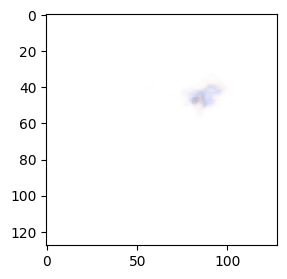

In [24]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.imshow(z[310,:,:,:],cmap='gray')

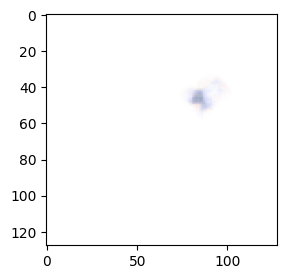

In [25]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.imshow(np.squeeze(z[312]),cmap='gray')

In [18]:
TRAIN_DATASET_PATH = 'C:\\Users\\Anita\\Datasets\\BraTS2021_Training_Data/'

example_case = 2 

# Set images path.
flair_path = os.path.join(TRAIN_DATASET_PATH, 'BraTS2021_{}'.format("%05d" %example_case),
                    'BraTS2021_{}_flair.nii.gz'.format("%05d" % example_case))

mask_path = flair_path.replace('flair', 'seg')
mask=mask_path

flair_image = nib.load(flair_path).get_fdata()
mask_image = nib.load(mask_path).get_fdata()
flair_image=scaler.fit_transform(flair_image.reshape(-1, flair_image.shape[-1])).reshape(flair_image.shape)
#flair_image=flair_image/np.max(flair_image)

print(flair_image.shape)
print(mask_image.shape)
print(flair_image.max())
print(flair_image.min())
print(mask_image.max())
print(mask_image.min())

#flair_image=scaler.fit_transform(flair_image.reshape(-1, flair_image.shape[-1])).reshape(flair_image.shape)

(240, 240, 155)
(240, 240, 155)
1.0
0.0
4.0
0.0


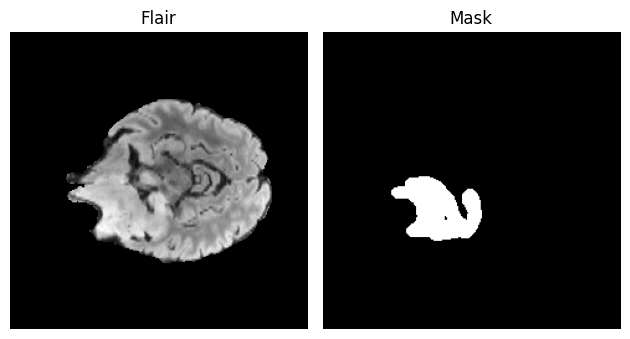

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)

slice2show=60
# Show T1w image w/overlayed mask.
ax1.imshow(flair_image[:,:,slice2show], cmap='gray')
#ax1.imshow(mask_path[:,:,slice2show], alpha=0.5, cmap='copper')
ax1.set_title('Flair')
ax1.set_axis_off()

#Show Mask image
ax2.imshow(mask_image[:,:,slice2show],cmap='gray')
ax2.set_title('Mask')
ax2.set_axis_off()
plt.tight_layout()
plt.show()

In [21]:
mask_image=cv2.resize(mask_image[:,:],(192,192))
mask_image.shape

flair_image=cv2.resize(flair_image[:,:],(192,192))
flair_image.shape
X = np.zeros((130,192,192,1))
for j in range(130):
    X[j,:,:,0] =flair_image[:,:,j+10]
X.shape

pred_wt=model.predict(X)

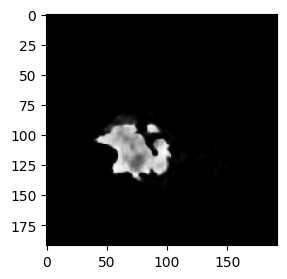

In [31]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.imshow(pred_wt[50,:,:,2],cmap='gray')

In [47]:
#pred_wt

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(33)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, dice, label='Training Dice Coeff.')
plt.plot(epochs_range, val_dice, label='Validation Dice Coeff.')
plt.legend(loc='best')
plt.title('Training and Validation Dice Coefficient')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, acc, label='Training Accuracy.')
plt.plot(epochs_range, val_acc, label='Validation Accuracy.')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.show()

NameError: name 'history' is not defined